Epoch 1/10 | Loss: 309.3944 | Train Acc: 57.52% | Val Acc: 57.50% | Val F1: 0.5480
Epoch 2/10 | Loss: 234.0307 | Train Acc: 77.94% | Val Acc: 71.38% | Val F1: 0.7052
Epoch 3/10 | Loss: 202.5886 | Train Acc: 85.12% | Val Acc: 66.50% | Val F1: 0.6619
Epoch 4/10 | Loss: 183.7221 | Train Acc: 89.85% | Val Acc: 72.12% | Val F1: 0.7217
Epoch 5/10 | Loss: 166.0154 | Train Acc: 94.12% | Val Acc: 75.19% | Val F1: 0.7540
Epoch 6/10 | Loss: 155.1226 | Train Acc: 96.44% | Val Acc: 77.56% | Val F1: 0.7721
Epoch 7/10 | Loss: 145.0958 | Train Acc: 98.44% | Val Acc: 76.62% | Val F1: 0.7645
Epoch 8/10 | Loss: 139.8625 | Train Acc: 99.02% | Val Acc: 74.62% | Val F1: 0.7488
Epoch 9/10 | Loss: 134.3712 | Train Acc: 99.77% | Val Acc: 72.44% | Val F1: 0.7291
Epoch 10/10 | Loss: 130.9210 | Train Acc: 99.92% | Val Acc: 76.56% | Val F1: 0.7635

Training Summary:

+---------+-------------+-----------+----------+-------+
|   Epoch |   Train Acc |   Val Acc |   Val F1 |    LR |
+=========+=============+==========

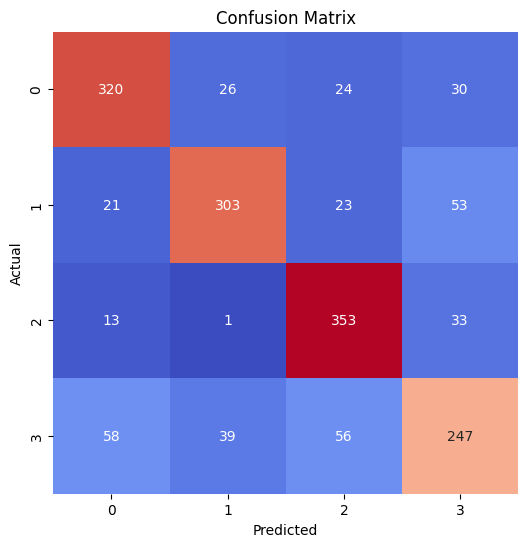

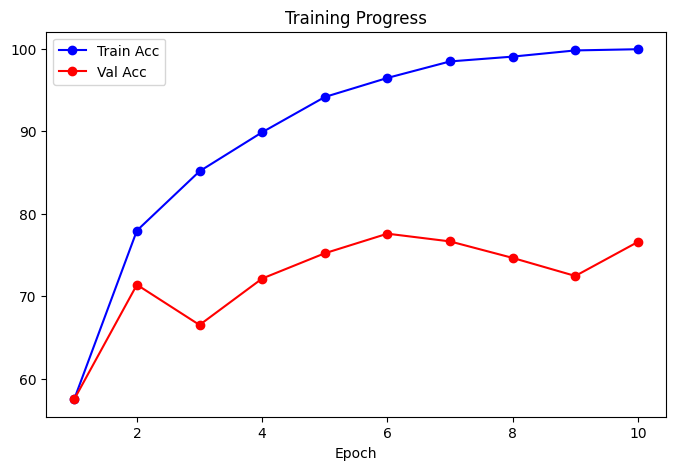

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from torch.nn.utils import prune
from vit_pytorch.simple_vit import SimpleViT
from tabulate import tabulate
from termcolor import colored

# Suppress CUDA error messages for clean output
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.benchmark = True

# Set device without printing errors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data with Optimized Transformations
def get_dataloader(batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train', transform=transform)
    test_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test', transform=transform)
    val_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\val', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

train_loader, test_loader, val_loader = get_dataloader()

# Define a Simple Vision Transformer
class SimpleVisionTransformer(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVisionTransformer, self).__init__()
        self.model = SimpleViT(
            num_classes=num_classes, image_size=128, dim=256, depth=3, heads=4, mlp_dim=512, patch_size=16
        )

    def forward(self, x):
        return self.model(x)

# Define a Simple CNN
class SemanticCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SemanticCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate models
teacher_model = SimpleVisionTransformer().to(device)
student_model = SemanticCNN().to(device)

# Knowledge Distillation Loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.7):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_loss = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_targets = nn.functional.log_softmax(student_logits / self.temperature, dim=1)
        teacher_targets = nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        loss_kl = self.kl_loss(soft_targets, teacher_targets) * (self.temperature ** 2)
        loss_ce = self.ce_loss(student_logits, labels)
        return self.alpha * loss_ce + (1 - self.alpha) * loss_kl

# Compute Accuracy & Confusion Matrix
def compute_metrics(model, dataloader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, f1, cm

# Train Model with Visualization & Beautiful Outputs
def train_model(teacher, student, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    loss_fn = DistillationLoss()

    results = []

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                teacher_outputs = teacher(images)

            student_outputs = student(images)
            loss = loss_fn(student_outputs, teacher_outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(student_outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train
        val_acc, val_f1, _ = compute_metrics(student, val_loader)
        results.append([epoch + 1, train_acc, val_acc, val_f1, lr])

        print(colored(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}", "cyan"))

    test_acc, test_f1, cm = compute_metrics(student, test_loader)

    # Print Beautiful Table
    table = tabulate(results, headers=["Epoch", "Train Acc", "Val Acc", "Val F1", "LR"], tablefmt="grid")
    print(colored("\nTraining Summary:\n", "green"))
    print(table)
    print(colored(f"\nFinal Test Accuracy: {test_acc:.2f}% | Test F1-score: {test_f1:.4f}\n", "magenta"))

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Training Visualization
    df = pd.DataFrame(results, columns=["Epoch", "Train Acc", "Val Acc", "Val F1", "LR"])
    df.plot(x="Epoch", y=["Train Acc", "Val Acc"], kind="line", marker="o", figsize=(8, 5), title="Training Progress", color=["blue", "red"])
    plt.show()

# Train and visualize
train_model(teacher_model, student_model, train_loader, val_loader, test_loader)
